In [1]:
import pandas as pd
from equipment.vdi.zbd import ZBD
#from kid_readout.analysis import dataframe
plt.rcParams['font.size'] = 11

In [2]:
# This represents the peak voltage V of a square wave with minimum at 0.
def zbd_voltage(lockin_rms_voltage):
    return 2**(-1/2) * np.pi * lockin_rms_voltage

# This is the RMS voltage of the first harmonic measured by the lock-in.
def lockin_rms_voltage(zbd_voltage):
    return 2**(1/2) / np.pi * zbd_peak_voltage

def zbd_power(zbd_voltage, optical_frequency=None):
    if optical_frequency is None:
        return zbd_voltage / 2200
    else:
        return zbd_voltage / ZBD().responsivity(optical_frequency)

In [3]:
def rectangle(df, H1, L1, H2, L2):
    mask_H1 = df.mickey == H1
    mask_L1 = df.mickey == L1
    mask_H2 = df.minnie == H2
    mask_L2 = df.minnie == L2
    HH = df[mask_H1 & mask_H2]
    HL = df[mask_H1 & mask_L2]
    LH = df[mask_L1 & mask_H2]
    LL = df[mask_L1 & mask_L2]
    return HH, HL, LH, LL

def extract_all(rectangle, key='zbd_voltage'):
    extracted = []
    for HH, HL, LH, LL in rectangle:
        for dummy, row_HH in HH.iterrows():
            for dummy, row_HL in HL.iterrows():
                for dummy, row_LH in LH.iterrows():
                    for dummy, row_LL in LL.iterrows():
                        extracted.append((row_HH[key], row_HL[key],
                                          row_LH[key], row_LL[key],
                                          ((row_HH[key] * row_LL[key]) /
                                           (row_HL[key] * row_LH[key]))))
    return extracted

def plot_rectangles(rectangles):
    fig, ax = plt.subplots()
    for r in rectangles:
        ax.plot(sorted([zbd_voltage_scale * r['HH'],
                        zbd_voltage_scale * r['HL'],
                        zbd_voltage_scale * r['LH'],
                        zbd_voltage_scale * r['LL']]),
                4 * [r['linearity']],
                '.-k', alpha=0.5)
    ax.set_xlabel('ZBD voltage [mV]')
    ax.set_ylabel('linearity')
    return fig, ax

In [4]:
df_filename = '/home/flanigan/equipment/vdi/calibration_broadband.npy'
df = pd.DataFrame().from_records(np.load(df_filename))

# Attempt to compensate for drift using a witness setting

In [5]:
df.sort('time', inplace=True)
mickey_witness = 160
minnie_witness = 160
witness = df[(df.mickey==mickey_witness) & (df.minnie==minnie_witness)]
first = witness[witness.time==witness.time.min()]
witness_ratio = witness.R / first.iloc[0].R
df['R_compensated'] = df.R / np.interp(df.time, witness.time, witness_ratio)

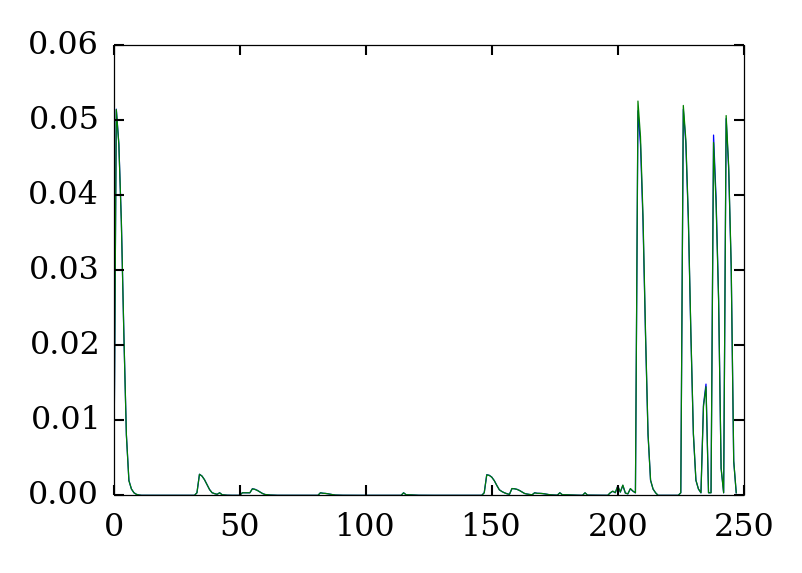

In [6]:
plt.plot(df.R)
plt.plot(df.R_compensated);

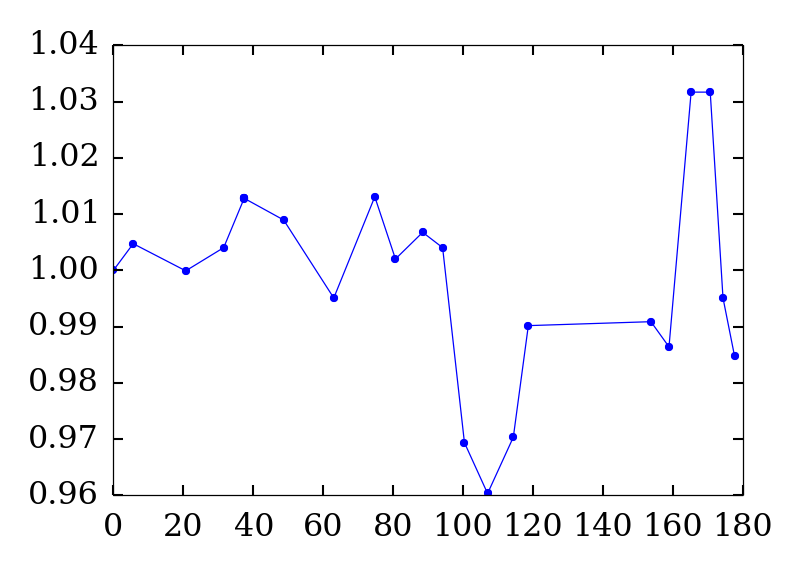

In [7]:
plt.plot((witness.time - witness.time.min()) / 60,
         witness_ratio,
         '.-');

In [8]:
# This will use the standard responsivity of 2200 V / W:
optical_frequency = None

df['zbd_voltage'] = zbd_voltage(df.R_compensated)

minimum_linear_zbd_voltage = 5e-7
maximum_linear_zbd_voltage = 0.9e-3

df['is_low'] = df.zbd_voltage < minimum_linear_zbd_voltage
df['is_linear'] = ((df.zbd_voltage >= minimum_linear_zbd_voltage) &
                   (df.zbd_voltage <= maximum_linear_zbd_voltage))
df['is_high'] = df.zbd_voltage > maximum_linear_zbd_voltage

#df['zbd_power_raw'] = zbd_power(df.R, optical_frequency)
#df['zbd_power'] = zbd_power(df.R_compensated, optical_frequency)

#minimum_linear_power = 2e-10
#maximum_linear_power = 0.5e-6  # 1e-6
#df['is_linear'] =  ((df.zbd_power >= minimum_linear_power) &
#                    (df.zbd_power <= maximum_linear_power))
#df['is_linear_raw'] =  ((df.zbd_power_raw >= minimum_linear_power) &
#                        (df.zbd_power_raw <= maximum_linear_power))

#df['is_low'] = df.zbd_power < minimum_linear_power
#df['is_high'] = df.zbd_power > maximum_linear_power

In [9]:
# Plot settings
zbd_voltage_scale = 1e3  # Plot voltage in mV
markersize = 5
xy_xlim = xy_ylim = (270, -10)
xy_xticks = xy_yticks = range(260, -20, -40)
xy_xlabel = 'Mickey'
xy_ylabel = 'Minnie'

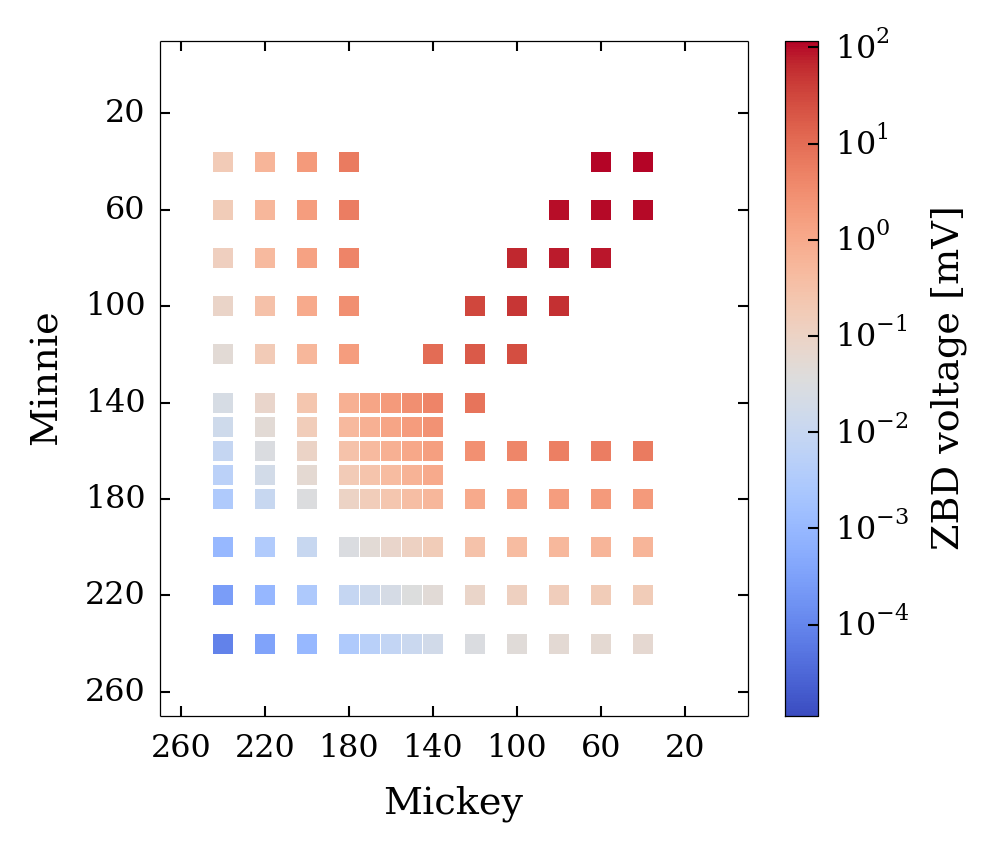

In [10]:
fig, ax = plt.subplots(figsize=(3.5, 3))
data = zbd_voltage_scale * df.zbd_voltage
norm = matplotlib.colors.LogNorm
mappable = plt.cm.ScalarMappable(norm(min(data), max(data)), cmap=plt.cm.coolwarm)
mappable.set_array(np.array(data))
for n, row in df.iterrows():
    ax.plot(row.mickey, row.minnie,
            color=mappable.to_rgba(zbd_voltage_scale * row.zbd_voltage),
            marker='s', markersize=markersize, markeredgecolor='none')
ax.set_xlim(*xy_xlim)
ax.set_xticks(xy_xticks)
ax.set_ylim(*xy_ylim)
ax.set_yticks(xy_yticks)
ax.set_xlabel(xy_xlabel)
ax.set_ylabel(xy_ylabel)
fig.colorbar(mappable, label=r'ZBD voltage [mV]');

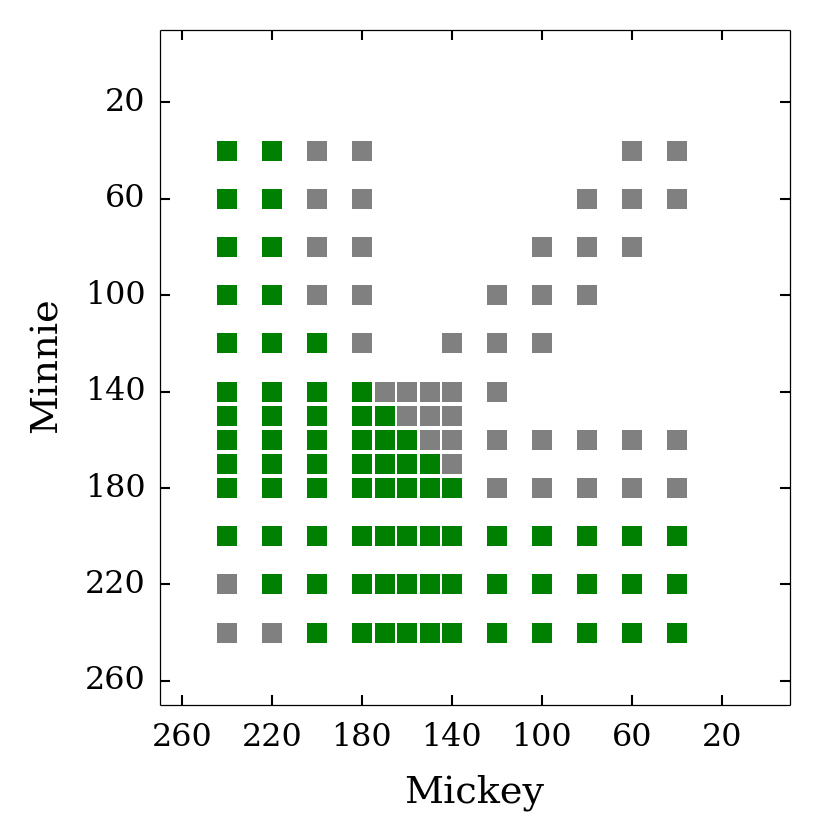

In [11]:
fig, ax = plt.subplots(figsize=(3, 3))
ax.plot(df.mickey[df.is_linear], df.minnie[df.is_linear],
        color='green', marker='s', markersize=markersize, markeredgecolor='none', linestyle='none')
ax.plot(df.mickey[~df.is_linear], df.minnie[~df.is_linear],
        color='gray', marker='s', markersize=markersize, markeredgecolor='none', linestyle='none')
ax.set_xlim(*xy_xlim)
ax.set_xticks(xy_xticks)
ax.set_ylim(*xy_ylim)
ax.set_yticks(xy_yticks)
ax.set_xlabel(xy_xlabel)
ax.set_ylabel(xy_ylabel);

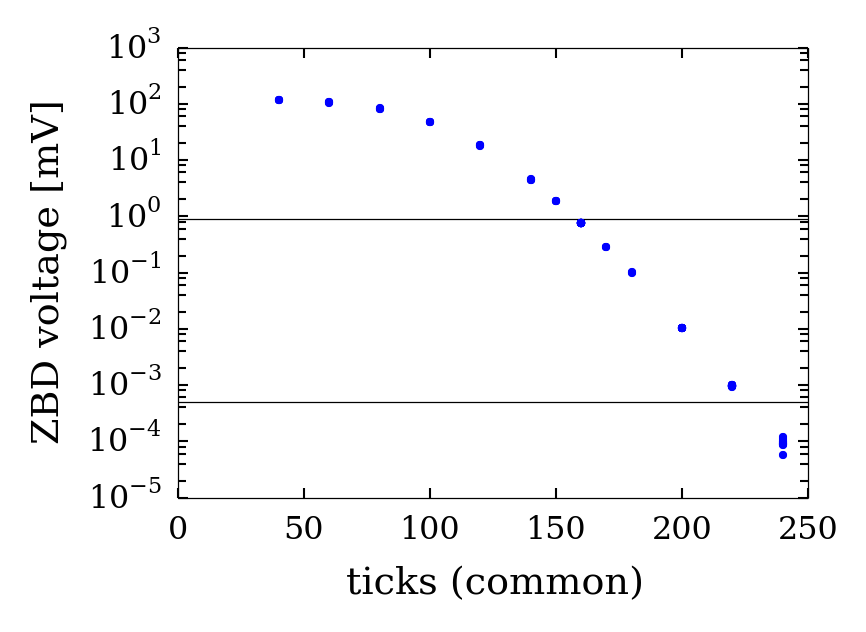

In [12]:
fig, ax = plt.subplots()
ax.axhline(zbd_voltage_scale * maximum_linear_zbd_voltage, color='k')
ax.axhline(zbd_voltage_scale * minimum_linear_zbd_voltage, color='k')
ax.semilogy(df[df.minnie==df.mickey].mickey,
            zbd_voltage_scale * df[df.minnie==df.mickey].zbd_voltage, '.');
ax.set_xlabel('ticks (common)')
ax.set_ylabel('ZBD voltage [mV]');

# Look at the effect of compensation

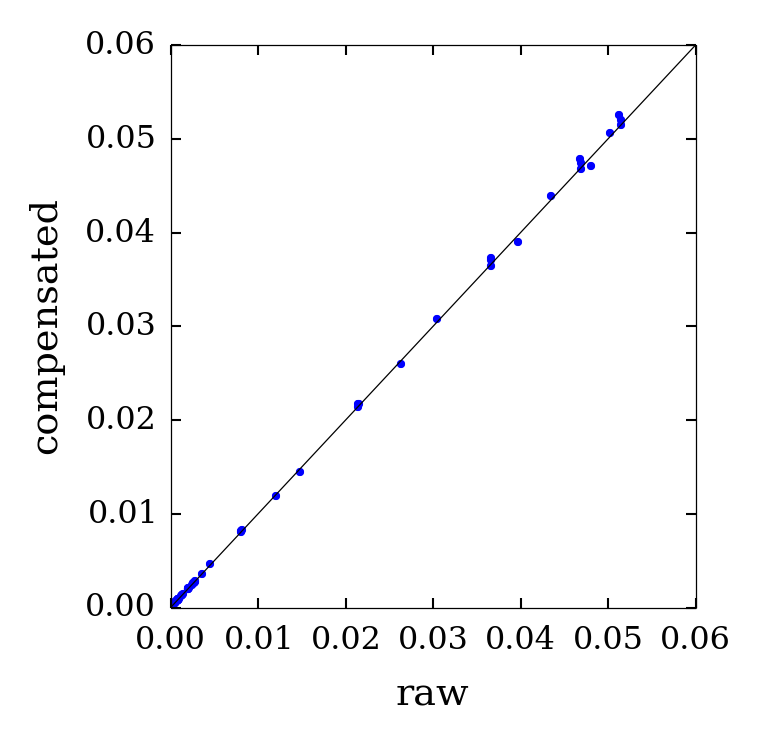

In [13]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
mask = df.is_high
ax.plot(df[mask].R, df[mask].R_compensated, '.')
ax.plot([0, 0.06], [0, 0.06], '-k')
ax.set_xlabel('raw')
ax.set_ylabel('compensated');

# Examine the data in the nominally linear region

In [14]:
linear_rectangles = []
mickey_unique = np.unique(df.mickey)
minnie_unique = np.unique(df.minnie)

for H1 in mickey_unique:
    for L1 in mickey_unique[mickey_unique > H1]:
        for H2 in minnie_unique:
            for L2 in minnie_unique[minnie_unique > H2]:
                HH, HL, LH, LL = rectangle(df[df.is_linear], H1, L1, H2, L2)
                if not HH.empty and not HL.empty and not LH.empty and not LL.empty:
                    linear_rectangles.append({'HH': HH.iloc[0].zbd_voltage,
                                              'HL': HL.iloc[0].zbd_voltage,
                                              'LH': LH.iloc[0].zbd_voltage,
                                              'LL': LL.iloc[0].zbd_voltage,
                                              'linearity': ((HH.iloc[0].zbd_voltage * LL.iloc[0].zbd_voltage) /
                                                            (HL.iloc[0].zbd_voltage * LH.iloc[0].zbd_voltage))})

In [15]:
len(linear_rectangles)

504

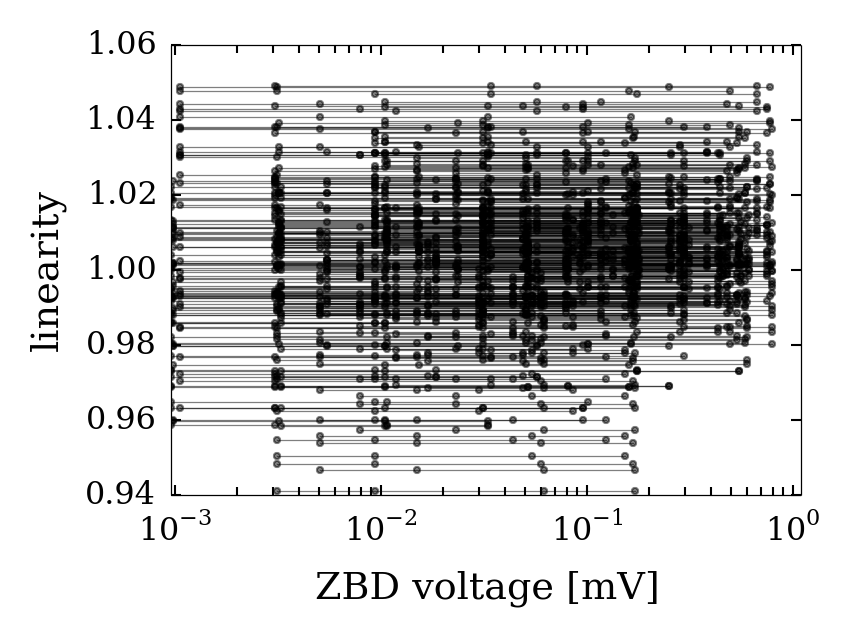

In [16]:
fig, ax = plot_rectangles(linear_rectangles)
ax.set_xscale('log')
ax.set_xlim(0, 1.1);

In [17]:
HHs = []
HLs = []
LHs = []
LLs = []
linearities = []
for rect in linear_rectangles:
    HHs.append(rect['HH'])
    HLs.append(rect['HL'])
    LHs.append(rect['LH'])
    LLs.append(rect['LL'])
    linearities.append(rect['linearity'])
HHs = np.array(HHs)
HLs = np.array(HLs)
LHs = np.array(HLs)
LLs = np.array(LLs)
linearities = np.array(linearities)

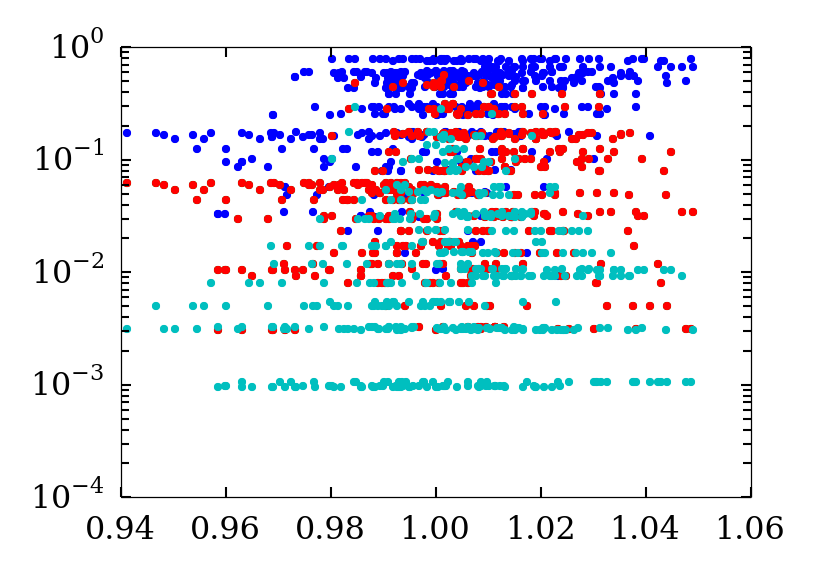

In [18]:
plt.semilogy(linearities, zbd_voltage_scale * HHs, '.', label='HH')
plt.semilogy(linearities, zbd_voltage_scale * HLs, '.', label='HL')
plt.semilogy(linearities, zbd_voltage_scale * LHs, '.', label='LH')
plt.semilogy(linearities, zbd_voltage_scale * LLs, '.', label='LL');

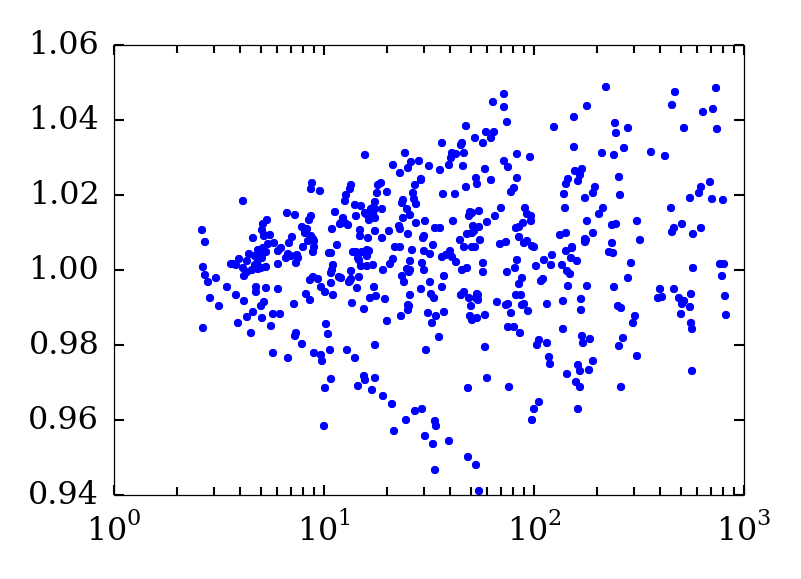

In [19]:
plt.semilogx(HHs / LLs, linearities, '.')

Mean linearity: 1.003
Median linearity: 1.004


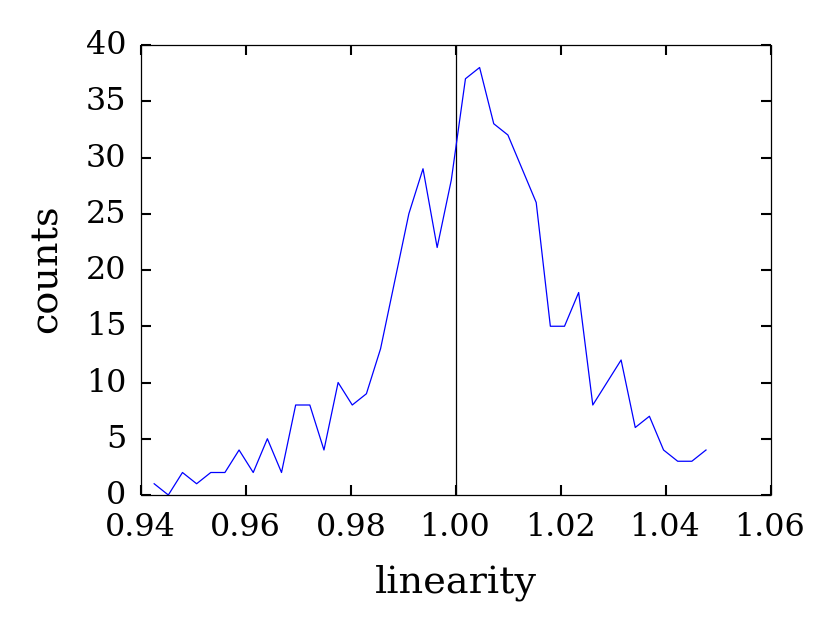

In [20]:
counts, bins = np.histogram(linearities, bins=40)
fig, ax = plt.subplots()
ax.axvline(1, color='black')
ax.plot((bins[:-1] + bins[1:])/2, counts, '-')
ax.set_xlabel('linearity')
ax.set_ylabel('counts')
print("Mean linearity: {:.3f}".format(np.mean(linearities)))
print("Median linearity: {:.3f}".format(np.median(linearities)))

Take the linearity in the nominally linear region to be 1:

In [21]:
df.loc[df.is_linear, 'linearity'] = 1.
df.loc[df.is_linear, 'linearity_error'] = 0.
df.loc[df.is_linear, 'linear_zbd_voltage'] = (df[df.is_linear].zbd_voltage /
                                              df[df.is_linear].linearity)

# Calibrate the low-power points using the linear region

low_rectangles = []
linear_mickey = np.unique(df[df.is_linear].mickey)
linear_minnie = np.unique(df[df.is_linear].minnie)
for index, row in df[df.is_low].iterrows():
    row_linearity = []
    for H1 in linear_mickey[linear_mickey < row.mickey]:
        for H2 in linear_minnie[linear_minnie < row.minnie]:
            HH, HL, LH, LL = rectangle(df, H1, row.mickey, H2, row.minnie)
            try:
                # If the three other points are in the linear region, calibrate LL.
                if (HH.iloc[0].is_linear and
                    HL.iloc[0].is_linear and
                    LH.iloc[0].is_linear):
                    linearity = ((HH.iloc[0].zbd_power * LL.iloc[0].zbd_power) /
                                 (HL.iloc[0].zbd_power * LH.iloc[0].zbd_power))
                    low_rectangles.append((HH.iloc[0].zbd_power,
                                           HL.iloc[0].zbd_power,
                                           LH.iloc[0].zbd_power,
                                           LL.iloc[0].zbd_power,
                                           linearity))
                    row_linearity.append(linearity)
            except IndexError:
                pass
    if len(row_linearity):
        df.loc[index, 'linearity'] = np.mean(row_linearity)
        df.loc[index, 'linearity_error'] = np.std(row_linearity)  # / len(row_linearity)**(1/2)
        df.loc[index, 'zbd_power_linear'] = row.zbd_power / np.mean(row_linearity)

len(low_rectangles)

fig, ax = plt.subplots()
ax.axhline(1, color='gray')

for index, row in df[df.is_low].iterrows():
#    ax.errorbar(1e6 * row.zbd_power, row.linearity, yerr=row.linearity_error,
    ax.plot(1e6 * row.zbd_power, row.linearity,
                marker='s', color='blue', linestyle='none', markeredgecolor='none')

for r in low_rectangles:
    ax.plot(1e6 * r[3], r[4], '.k', ms=2)
ax.set_ylim(0.97, 1.13)

ax.set_xlabel('ZBD power [$\mu$W]')
ax.set_ylabel('linearity')
ax.set_title(r'low power: $P < 1 \, \mu \mathrm{W}$');

# Calibrate the high-power points using the linear region

In [22]:
key = 'zbd_voltage'

high_rectangles = []
linear_mickey = np.unique(df[df.is_linear].mickey)
linear_minnie = np.unique(df[df.is_linear].minnie)
for index, row in df[df.is_high].iterrows():
    row_linearity = []
    for L1 in linear_mickey[linear_mickey > row.mickey]:
        for L2 in linear_minnie[linear_minnie > row.minnie]:
            HH, HL, LH, LL = rectangle(df, row.mickey, L1, row.minnie, L2)
            try:
                if (LL.iloc[0].is_linear and
                    HL.iloc[0].is_linear and
                    LH.iloc[0].is_linear):
                    linearity = ((HH.iloc[0][key] * LL.iloc[0][key]) /
                                 (HL.iloc[0][key] * LH.iloc[0][key]))
                    high_rectangles.append({'HH': HH.iloc[0][key],
                                            'HL': HL.iloc[0][key],
                                            'LH': LH.iloc[0][key],
                                            'LL': LL.iloc[0][key],
                                            'linearity': linearity})
                    row_linearity.append(linearity)
            except IndexError:
                continue
    if len(row_linearity):
        df.loc[index, 'linearity'] = np.mean(row_linearity)
        df.loc[index, 'linearity_error'] = np.std(row_linearity)  # / len(row_linearity)**(1/2)
        df.loc[index, 'linear_zbd_voltage'] = row[key] / np.mean(row_linearity)

len(high_rectangles)

697

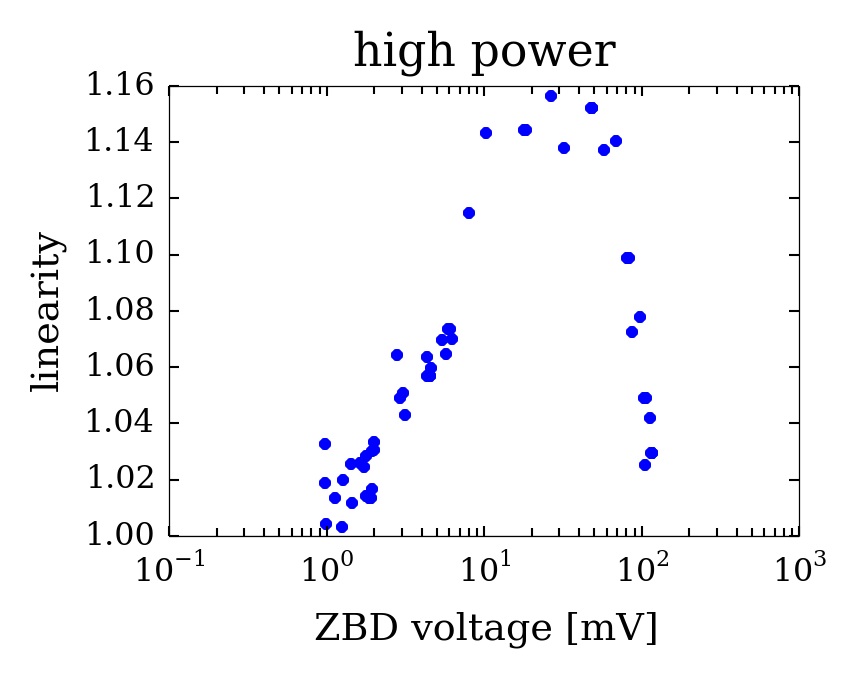

In [23]:
fig, ax = plt.subplots()
ax.axhline(1, color='gray')

for index, row in df[df.is_high].iterrows():
#    ax.errorbar(zbd_voltage_scale * row.zbd_voltage,
#                row.linearity,
#                yerr=row.linearity_error,
    ax.plot(zbd_voltage_scale * row.zbd_voltage,
                row.linearity,              
            marker='o', color='blue', linestyle='none', markeredgecolor='none')

#for r in high_rectangles:
#    ax.plot(1e6 * r[0], r[4], '.k', ms=2)

ax.set_xscale('log')
ax.set_xlabel('ZBD voltage [mV]')
ax.set_ylabel('linearity')
ax.set_title('high power');

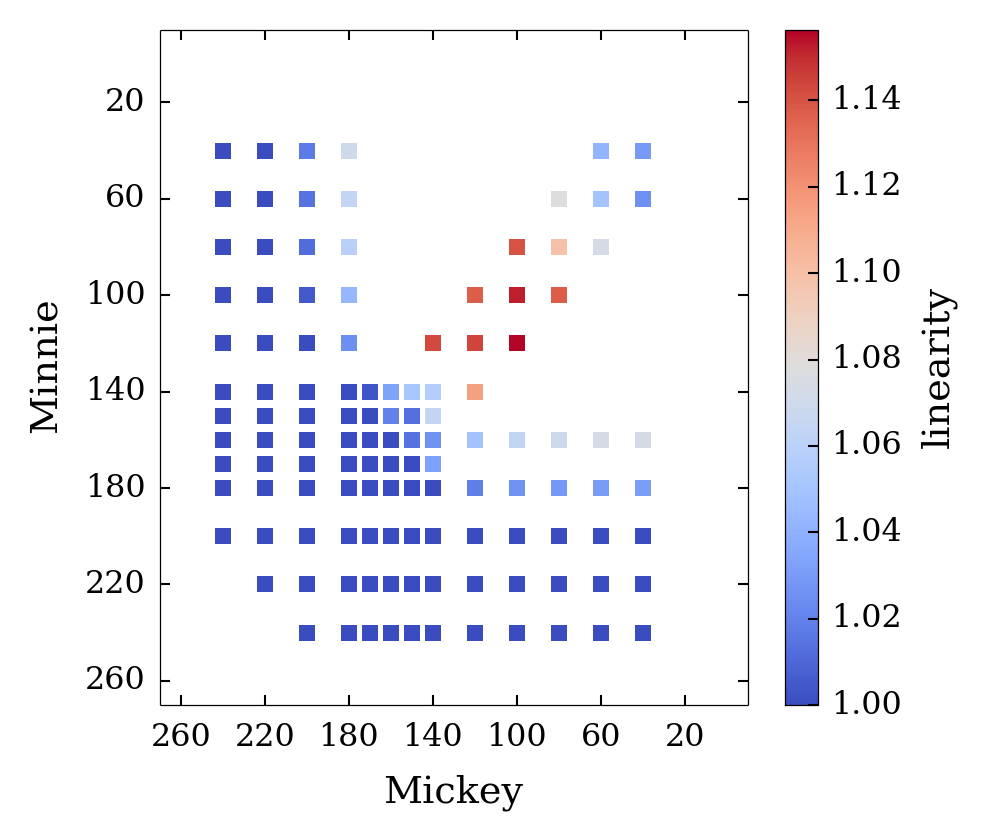

In [24]:
fig, ax = plt.subplots(figsize=(3.5, 3))
data = np.unique(np.concatenate((df.linearity, df.linearity)))
norm = matplotlib.colors.Normalize
mappable = plt.cm.ScalarMappable(norm(min(data), max(data)), cmap=plt.cm.coolwarm)
mappable.set_array(np.array(data))
for n, row in df[~df.linearity.isnull()].iterrows():
    ax.plot(row.mickey, row.minnie, color=mappable.to_rgba(row.linearity),
            marker='s', markersize=4, markeredgecolor='none')
ax.set_xlim(*xy_xlim)
ax.set_xticks(xy_xticks)
ax.set_ylim(*xy_ylim)
ax.set_yticks(xy_yticks)
ax.set_xlabel(xy_xlabel)
ax.set_ylabel(xy_ylabel)
fig.colorbar(mappable, label='linearity');

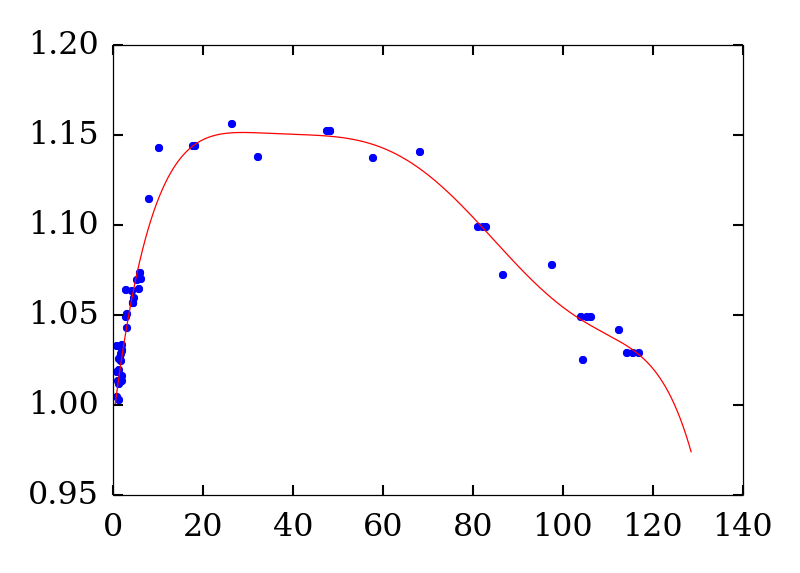

In [25]:
high_zbd_voltage = df[df.is_high].zbd_voltage
high_linearity = df[df.is_high].linearity
high_linearity_error = df[df.is_high].linearity_error

minimum_high_zbd_voltage = high_zbd_voltage.min()
maximum_high_zbd_voltage = high_zbd_voltage.max()
V = np.linspace(1/2 * minimum_high_zbd_voltage, 1.1 * maximum_high_zbd_voltage, 1e3)
P = np.polyfit(high_zbd_voltage, high_linearity, 6)

fig, ax = plt.subplots()
ax.plot(zbd_voltage_scale * high_zbd_voltage,
        high_linearity, '.')
ax.plot(zbd_voltage_scale * V, np.polyval(P, V), '-r')

In [26]:
np.save('/home/flanigan/equipment/vdi/high_linearity_polynomial.npy',
        P)
np.save('/home/flanigan/equipment/vdi/high_linearity_domain.npy',
        (minimum_high_zbd_voltage, maximum_high_zbd_voltage))